# Import Library

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

# Definisi Fungsi Utama Steganografi

In [ ]:
def message_to_binary(message):
    """Mengubah pesan string menjadi representasi biner."""
    binary_message = ''.join(format(ord(char), '08b') for char in message)
    return binary_message

def encode_message_in_image(image_path, secret_message, output_path):
    """Menyisipkan pesan rahasia ke dalam gambar menggunakan LSB."""
    if not os.path.exists(image_path):
        print(f"❌ Error: File input '{image_path}' tidak ditemukan. Pastikan path dan nama file sudah benar.")
        return

    image = cv2.imread(image_path)
    if image is None:
        # Tambahan: Cek apakah format file adalah JPEG dan coba penanganan berbeda jika perlu
        if image_path.lower().endswith(('.jpeg', '.jpg')):
            print("⚠️ Peringatan: Anda menggunakan gambar JPEG. Format ini bersifat 'lossy' dan dapat merusak pesan tersembunyi saat disimpan ulang.")
        else:
            print(f"Error: Tidak bisa membaca gambar dari {image_path}. Pastikan file bukan corrupt.")
            return

    max_bytes = image.shape[0] * image.shape[1] * 3 // 8
    print(f"Ukuran gambar: {image.shape[0]}x{image.shape[1]} piksel. Kapasitas maksimum: {max_bytes} bytes.")

    secret_message += "#####" # Delimiter
    binary_secret_message = message_to_binary(secret_message)

    if len(binary_secret_message) > max_bytes * 8:
        print("Error: Pesan terlalu panjang untuk disembunyikan di dalam gambar ini.")
        return

    print(f"Menyisipkan pesan '{secret_message[:-5]}' ({len(binary_secret_message)} bit)...")

    data_index = 0
    for row in image:
        for pixel in row:
            for i in range(3):
                if data_index < len(binary_secret_message):
                    pixel[i] = int(format(pixel[i], '08b')[:-1] + binary_secret_message[data_index], 2)
                    data_index += 1
                else: break
            if data_index >= len(binary_secret_message): break
        if data_index >= len(binary_secret_message): break

    # Simpan output. Untuk JPEG, kualitas harus diatur 100 untuk meminimalisir kompresi ulang.
    if output_path.lower().endswith(('.jpeg', '.jpg')):
        cv2.imwrite(output_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    else:
        cv2.imwrite(output_path, image) # Simpan sebagai PNG secara default

    print(f"✅ Pesan berhasil disisipkan. Gambar baru disimpan sebagai '{output_path}'")

def decode_message_from_image(image_path):
    """Mengekstrak pesan rahasia dari gambar LSB."""
    if not os.path.exists(image_path):
        print(f"❌ Error: File '{image_path}' tidak ditemukan untuk didekode.")
        return None

    image = cv2.imread(image_path)
    binary_data = ""
    for row in image:
        for pixel in row:
            for i in range(3):
                binary_data += format(pixel[i], '08b')[-1]

    all_bytes = [binary_data[i: i+8] for i in range(0, len(binary_data), 8)]

    decoded_message = ""
    for byte in all_bytes:
        if len(byte) == 8:
            decoded_message += chr(int(byte, 2))
            if decoded_message[-5:] == "#####":
                return decoded_message[:-5]

    return None

# Path Gambar

In [ ]:
# Tentukan path file gambar yang sudah ada di Colab
original_image_name = "/content/pic.png"

# Kode ini akan memeriksa apakah path yang Anda masukkan sudah benar
if os.path.exists(original_image_name):
    print(f"✅ File ditemukan di: '{original_image_name}'. Siap digunakan.")
else:
    print(f"❌ Error: File tidak ditemukan di '{original_image_name}'.")
    print("Pastikan Anda sudah mengunggah file 'ishowspeed.jpg' ke direktori utama (/content/).")

✅ File ditemukan di: '/content/pic.png'. Siap digunakan.


## Menyisipkan Pesan "Hello"

In [ ]:
output_hello_path = "ishowspeed_dengan_hello.png"
encode_message_in_image(original_image_name, "Hello", output_hello_path)

Ukuran gambar: 600x800 piksel. Kapasitas maksimum: 180000 bytes.
Menyisipkan pesan 'Hello' (80 bit)...
✅ Pesan berhasil disisipkan. Gambar baru disimpan sebagai 'ishowspeed_dengan_hello.png'


## Menambahkan Watermark "Protected"

In [ ]:
output_protected_path = "ishowspeed_dengan_watermark.png"
encode_message_in_image(original_image_name, "Protected", output_protected_path)

Ukuran gambar: 600x800 piksel. Kapasitas maksimum: 180000 bytes.
Menyisipkan pesan 'Protected' (112 bit)...
✅ Pesan berhasil disisipkan. Gambar baru disimpan sebagai 'ishowspeed_dengan_watermark.png'


# Verifikasi dan Perbandingan Visual

## Verifikasi dengan Mengekstrak Pesan

In [12]:
# Dekode pesan dari gambar pertama
decoded_hello = decode_message_from_image(output_hello_path)
print(f"Pesan yang diekstrak dari '{output_hello_path}': {decoded_hello}")

# Dekode pesan dari gambar kedua
decoded_protected = decode_message_from_image(output_protected_path)
print(f"Pesan yang diekstrak dari '{output_protected_path}': {decoded_protected}")

Pesan yang diekstrak dari 'ishowspeed_dengan_hello.png': Hello
Pesan yang diekstrak dari 'ishowspeed_dengan_watermark.png': Protected


## Perbandingan Visual Gambar

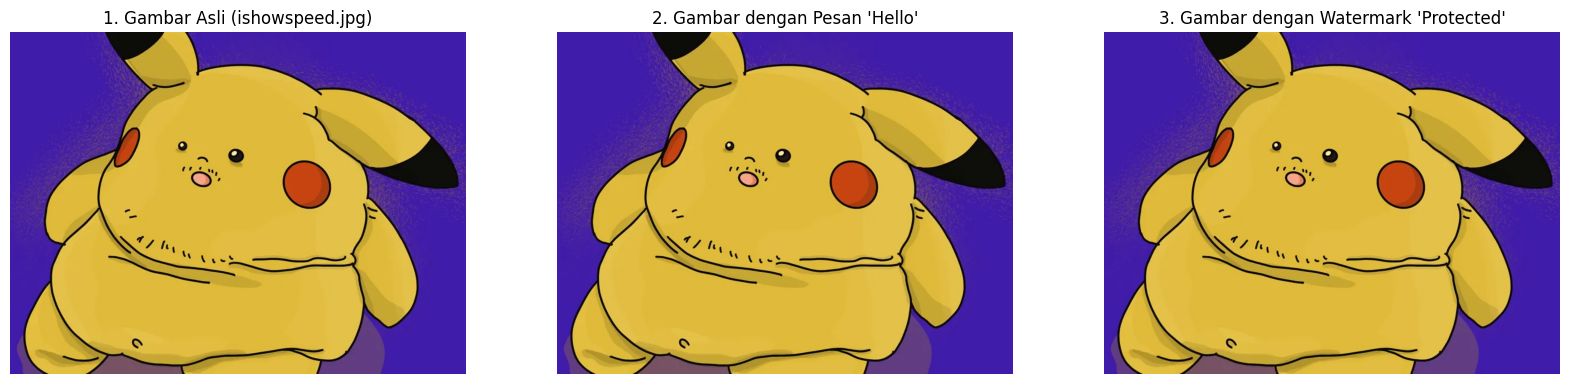

In [13]:
# Baca semua gambar untuk ditampilkan
img_original = cv2.imread(original_image_name)
img_hello = cv2.imread(output_hello_path)
img_protected = cv2.imread(output_protected_path)

# Konversi warna dari BGR (standar OpenCV) ke RGB (standar Matplotlib)
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_hello_rgb = cv2.cvtColor(img_hello, cv2.COLOR_BGR2RGB)
img_protected_rgb = cv2.cvtColor(img_protected, cv2.COLOR_BGR2RGB)

# Buat plot untuk perbandingan
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(img_original_rgb)
axes[0].set_title("1. Gambar Asli (ishowspeed.jpg)")
axes[0].axis('off')

axes[1].imshow(img_hello_rgb)
axes[1].set_title("2. Gambar dengan Pesan 'Hello'")
axes[1].axis('off')

axes[2].imshow(img_protected_rgb)
axes[2].set_title("3. Gambar dengan Watermark 'Protected'")
axes[2].axis('off')

plt.show()